#  Indirect dark matter detection detection constatints in the SDFDM

We expect here degenerate masses so we must be carefull about the DM particles that is registered by micrOMEGAS:

We need to edit prtcls1.mld to have the righ order with Nv0 appearing first

In [187]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [188]:
%%writefile run_point.py
import pandas as pd
import numpy as np
import os, sys, inspect
import commands
from hep import *
import pdg_series
#from indirectdirect import *
from straightfits import *
from multicurvefit import *
import stu_sdfdm as stu
import time
from matplotlib.colors import LogNorm

Omega_h2_EXP=np.array([0.1197-0.0044,0.1197,0.1197+0.0044])
h_to_AA=2.270E-03
#R_AA=np.array([1.15-0.25,1.15,1.15+0.27])
R_AA=np.array([1.05-0.25,1.15,1.05+0.27]) #fast combination Run1+Run2
LUX=multicurvefit()
AMS=multicurvefit()
LHC_cs=multicurvefit()
LHC_exc_cs=multicurvefit()
LUX.read_json('lux2016.json')
AMS.read_json('ID_max.json')
LHC_cs.read_json('SDFDM_cs.json')
LHC_exc_cs.read_json('SDFDM_exc_cs.json')
MODEL='SimplifiedDMSDFDM'


def Oh2(df,Omega_h2_EXP=Omega_h2_EXP):
    return df[ np.logical_and(df.Omega_h2<Omega_h2_EXP[2],df.Omega_h2>Omega_h2_EXP[0]) ].reset_index(drop=True)
def cuts_series(ps):
    Br_inv=0.19
    STU=0.2
    cuts={}
    cuts['cuts_a_Omega_h2']=(ps.Omega_h2<=Omega_h2_EXP[2])
    cuts['cuts_b_Br_inv']=(ps['h0 ->  Chi_1 Chi_1']<Br_inv)
    cuts['cuts_c_R_gamma_gamma']=(ps['h0 ->  PHOT PHOT']/h_to_AA>R_AA[0] and ps['h0 ->  PHOT PHOT']/h_to_AA<R_AA[2])
    cuts['cuts_d_z_DD']=(ps.z_DD_SI<ps.lux_SI)
    cuts['cuts_e_LHC']=(ps.LHC_cs_br<ps.LHC_exc_cs)
    if np.abs(ps.MDF)<100:
        cuts['cuts_e_LHC']=False
    cuts['cuts_f_STU']=(ps.T_par_new<STU)
    cuts['cuts_all']=True
    if False in cuts.values():
        cuts['cuts_all']=False
#    cf['f']=cf.e[cf.e.T_par_new<0.2]
    return pd.Series(cuts)
def run_point(MN,MDF,lam,tanb,MODEL=MODEL):
        a=hep(MODEL=MODEL)
        ps=pd.Series()
        lu=lam*np.sin(np.arctan(tanb))
        ld=lam*np.cos(np.arctan(tanb))
        devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
        a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
        a.LHA.blocks['MINPAR'][2]='%0.8E       # MDF' %MDF
        a.LHA.blocks['MINPAR'][3]='%0.8E       # MnINPUT' %MN
        a.LHA.blocks['MINPAR'][4]='%0.8E       # lamuINPUT' %lu
        a.LHA.blocks['MINPAR'][5]='%0.8E       # lamdINPUT' %ld
        moc=a.runmicromegas(Direct_Detection=True)
        #print 'Omega h^2, SI proton, neutron, MChi =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI,\
        a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
        #manual pdgs:
        a.pdg['Frep']=-210000601
        a.branchings(a.LHA_out.decays,min_pdg=23)
        a.Series['sigma_chi0_chipm']=0.3 #pb from fig. 15 of arXiv:1411.1335
        a.Series['Chi_1']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
        a.Series['Chi_2']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_2]
        a.Series['Chi_3']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_3]
        a.Series['Fre']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Fre]
        ps=ps.append(a.Series)
        ps=ps.append(a.Br_names)
        ##FUll colums
        chkbr=['Chi_2 ->  Chi_1 Z0','Fre ->  Chi_1 W-','h0 ->  Chi_1 Chi_1','h0 ->  PHOT PHOT','Z0 ->  Chi_1 Chi_1']
        for k in chkbr:
            if not k in ps:
                ps[k]=0
        ps['tanb']=ps.lamuINPUT/ps.lamdINPUT
        ps['lambda']=np.sqrt(ps.lamuINPUT**2+ps.lamdINPUT**2)
        ps['lam']=ps['lambda']
        #Rescale DD and ID
        ps['DD_SI']=max(ps.proton_SI,ps.neutron_SI)
        ps['z_DD_SI']=ps.Omega_h2/Omega_h2_EXP[1]*ps.DD_SI
        ps['z2_sigmav']=ps.Omega_h2**2/Omega_h2_EXP[1]**2*ps.sigmav 
        ps['T_par_new']=stu.stu_new(ps.MnINPUT,ps.MDF,ps.lam,ps.tanb,vev=a.vev) #T is transpose
        
        
        ps['lux_SI']=LUX(ps.Chi_1)
        ps['AMS_ID_bb']=AMS(ps.Chi_1)
        ps['LHC_cs']=LHC_cs(np.abs(ps.MDF))
        ps['LHC_exc_cs']=LHC_exc_cs( np.abs(ps.MDF) )
        ps['LHC_cs_br']=ps.LHC_cs*ps['Chi_2 ->  Chi_1 Z0']*ps['Fre ->  Chi_1 W-']
        return ps
    



Overwriting run_point.py


In [189]:
from run_point import *
a=hep(MODEL=MODEL)

In [195]:
scan=True
REWRITE=True
IGNORE_CELL=True
if IGNORE_CELL:
    scan=False
    REWRITE=False

# Jump directly to the analysis [here](#analysis),
or follow to the next cell to re-create the main DataFrame

## Feynrules implementation
[Preliminary Analysis](../../../../../2016/micromegas_feynrules/correr_micrOMEGAs-markov.ipynb)

See also full results with user galcen in fisica? or gfif?


## Benchmark point

We choose a benchmark point with the following features
* Large $\langle\sigma v\rangle$
* Right relic density

In [4]:
from run_feynrules_SDFM import *

In [5]:
%%bash
cd ../micromegas/SDFDM
make main=main.c > /dev/null

## Parameter scan

`a-object` is an object with many attributes and methods. Use the tab to explore them. Some of them are
* a.Series: [pandas](http://pandas.pydata.org/) Series object with the "relevant" variables 
* a.LHA: Input LesHouces file as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runSPheno() -> a.LHA_out: return LHA output files as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runmicromegas() -> a.runSPheno() -> Updated the `a-object`  with micrOMEGAS "relevant" output

List of constraints for DM=37 GeV and MD=200 GeV
* $\sigma(\chi_{2,3}^0,\chi^\pm)\operatorname{Br}(\chi^\pm \to \chi_1^0 W^\pm)\operatorname{Br}(\chi_2^0 \to \chi_1^0 Z)<0.3\ \text{pb}$ from fig. 15 of [arXiv:1411.1335](http://arxiv.org/pdf/1411.1335v2)
## Check benchmark point

In [4]:
#IGNORE_CELL=False
if not IGNORE_CELL:
    v=a.vev
    #lambda_1=0.13
    if 1==1:
        mdf=-214.058784
        MN=29.248824
        tanb=24.215051
        lam=0.711271        
        ps=run_point(MN,mdf,lam,tanb)

In [36]:
if not IGNORE_CELL:
    scan=True # If false load the data from the saved scan files below

In [37]:
start=time.time()
if scan and not IGNORE_CELL:
    pf=pd.DataFrame()
    fulld=pd.DataFrame()
    v=a.vev
    mdf=-200; MN=40; tanb=100.;lam=0.35
    npoints=1
    i=0
    for mdf in -np.logspace(np.log10(100),np.log10(1000),npoints):
        i=i+1
        if i%1000==0: print i
        MN=np.random.uniform(10,50)
        tanb=np.random.uniform(1,100)
        lam=np.random.uniform(0.1,3)
        run_point(MN,mdf,lam,tanb)
        pf=pf.append(ps,ignore_index=True)
        pf=pf.fillna(0)
        #Full backup of data: WARNING: HUGE File
        fulls=pd.Series()
        if os.path.isfile('SPheno.spc.%s' %a.MODEL):
            f=open('SPheno.spc.%s' %a.MODEL).read()
            fulls['SPheno']=f
            fulls['micromegas']=moc
            
        fulld=fulld.append(fulls,ignore_index=True)

stop=time.time()
trun=stop-start
pd.DataFrame({'t':[trun]}).to_csv('trun.csv')

In [57]:
if scan and not IGNORE_CELL: 
    pf.to_csv('scan_full_4.csv',index=False)
    fulld.to_pickle('scan_full_4.pkl')

In [203]:
if not scan: #load the data from the saved scan files
    pf=pd.read_csv('scan_full.csv')
    pf=pf.append(pd.read_csv('scan_full_2.csv'))
    ##pf=pd.read_csv('scan_full_3.csv')
    
    pf=pf.append(pd.read_csv('scan_full_3.csv'))
    
    pf['ID_br:~Chi1,~Chi1 -> d3 D3']=pf['ID_br:~chi,~chi > b b~']
    pf['ID_br:~Chi1,~Chi1 -> u2 U2']=pf['ID_br:~chi,~chi > c c~']
    pf['ID_br:~Chi1,~Chi1 -> e3 E3']=pf['ID_br:~chi,~chi > ta t']
    pf=pf.append(pd.read_csv('scan_full_4.csv'))
    pf=pf.append(pd.read_csv('scan_full_5.csv'))
    #pf=pd.read_csv('scan_full_6.csv')
    pf=pf.append(pd.read_csv('scan_full_6.csv'))
    pf=pf.append(pd.read_csv('scan_full_7.csv'))
    pf=pf.append(pd.read_csv('scan_full_8.csv'))
    pf=pf.append(pd.read_csv('scan_full_tmp.csv'))
    pf=pf.fillna(0)
    pf=pf.sort_values('Chi_1')
    pf=pf.reset_index(drop=True)

In [ ]:
if FIX_POINTS:
    pg=pd.DataFrame()
    for i in range(pf.shape[0]):
        if i%1000==0: print i
        ps=pf.ix[i]
        ps=run_point(ps.MnINPUT,ps.MDF,ps.lam,ps.tanb)
        pg=pg.append(ps,ignore_index=True)

In [204]:
if not REWRITE:
    pf['tanb']=pf.lamuINPUT/pf.lamdINPUT
    pf['lambda']=np.sqrt(pf.lamuINPUT**2+pf.lamdINPUT**2)
    pf['lam']=pf['lambda']
    #Rescale DD and ID
    pf['DD_SI']=0
    if pf[pf.proton_SI>pf.neutron_SI].shape[0]==0:
        pf['DD_SI']=pf.neutron_SI
    else:
        for i in range(pf.shape[0]):
            pf=pf.reset_index(drop=True)
            pf.loc[i,'DD_SI']=max(pf.proton_SI[i],pf.neutron_SI[i])

    pf['z_DD_SI']=pf.Omega_h2/Omega_h2_EXP[1]*pf.DD_SI

    pf['z2_sigmav']=pf.Omega_h2**2/Omega_h2_EXP[1]**2*pf.sigmav 

    print pf.shape

(37065, 226)


## STU parameters
https://fisica.udea.edu.co:4443/user/galcen/notebooks/gce_t13a.ipynb

(See also http://gfif.udea.edu.co:4443/user/rsiii/edit/RS3/IDM/rsiii_lhc_analysis/DM_scan.py)

New $V_{ij}$ elements : http://arxiv.org/abs/0705.4493

By using

`In[1]:= Limit[(2 x y (x^2 + y^2) - x^4 - y^4)/(x^2 - y^2) Log[x^2/y^2], x -> y]`

`Out[1]:= 2y^2`

`In[1]:= Limit[(2 x y (x^2 + y^2) - x^4 - y^4)/(x^2 - y^2) Log[x^2/y^2], x -> -y]`

`Out[1]:= -6y^2`

From eq. (43)

if $m_1\ne m_2$
\begin{align}
&(m_1-m_2)^2\log[\Lambda^4/(m_1^2 m_2^2)]-2m_1m_2+\frac{[ 2m_1m_2(m_1^2+m_2^2)-m_1^4-m_2^4 ]}{ m_1^2-m_2^2}\log(m_1^2/m_2^2)
\end{align}

if $m_1\to m_2$
\begin{align}
&(m_1-m_2)^2\log[\Lambda^4/(m_1^2 m_2^2)]-2m_1m_2+\frac{[ 2m_1m_2(m_1^2+m_2^2)-m_1^4-m_2^4 ]}{ m_1^2-m_2^2}\log(m_1^2/m_2^2)\\
&0-2m_1^2+2m_1^2\\
&0
\end{align}



if $m_1\to -m_2$
\begin{align}
&(m_1-m_2)^2\log[\Lambda^4/(m_1^2 m_2^2)]-2m_1m_2+\frac{[ 2m_1m_2(m_1^2+m_2^2)-m_1^4-m_2^4 ]}{ m_1^2-m_2^2}\log(m_1^2/m_2^2)\\
&4m_1^2\log[\Lambda^4/(m_1^4)]+2m_1^2-6m_1^2\\
&4m_1^2\{-1+\log[\Lambda^4/(m_1^4)]\}
\end{align}

See: the implementation in the secon part of `stu_sdfdm.py` for arXiv:0705.4493

In [77]:
v=a.vev
MN=30;MDF=-200;lu=2.;ld=0.1
stu.stumap_new(MN,MDF,np.sqrt(lu**2+ld**2),lu/ld,v)

array(2.948815963929462)

Test $\Pi(0)$ in eq. (43)

In [78]:
np.testing.assert_almost_equal(stu.A(10,-10),stu.A(10,-10.0000001),decimal=5)
np.testing.assert_almost_equal(stu.A(10,10),stu.A(10,10.0000001),decimal=5)

In [79]:
print stu.stu_new(-MN,MDF,np.sqrt(lu**2+ld**2),lu/ld,v),stu.stu_new(MN,-MDF,np.sqrt(lu**2+ld**2),lu/ld,v),\
       stu.stu_new(MN,-MDF,np.sqrt(lu**2+ld**2),ld/lu,v),stu.stu_new(MN,-MDF,np.sqrt(lu**2+ld**2),-lu/ld,v),\
       stu.stu_new(MN,-MDF,np.sqrt(lu**2+ld**2),-ld/lu,v),stu.stu_new(-MN,-MDF,np.sqrt(lu**2+ld**2),-ld/lu,v)

3.07178341927 3.07178341927 3.07178341927 2.94881596393 2.94881596393 3.07178341927


## Prepare full data frame

### Full data set

In [109]:
if not REWRITE:
    SLOW_CELL=False
    if SLOW_CELL:
        start=time.time()
        pf['T_par']=stu.stumap(pf.MnINPUT.values,pf.MDF.values,pf.lam.values,pf.tanb.values,vev=a.vev) #T is transpose
        print 'Execution Time:',time.time()-start

In [205]:
if not REWRITE:
    start=time.time()
    pf['T_par_new']=stu.stumap_new(pf.MnINPUT.values,pf.MDF.values,pf.lam.values,pf.tanb.values,vev=a.vev) #T is transpose
    print 'Execution Time:',time.time()-start

Execution Time: 10.3525841236


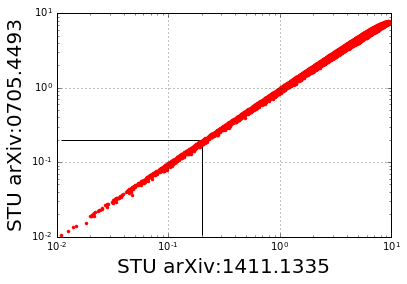

In [18]:
if SLOW_CELL:
    plt.loglog(pf.T_par,pf.T_par_new,'r.')
    plt.xlabel('STU arXiv:1411.1335',size=20)
    plt.ylabel('STU arXiv:0705.4493',size=20)
    plt.hlines(0.2,pf.T_par.min(),0.2)
    plt.vlines(0.2,pf.T_par_new.min(),0.2)
    plt.grid()

### Load constraints

In [206]:
if not REWRITE:
    start=time.time()
    pf['lux_SI']=LUX(pf.Chi_1)

    pf['AMS_ID_bb']=AMS(pf.Chi_1)


    pf['MDF_abs']=pf.MDF.abs() #reorder to add collider constraints in the fast way
    pf=pf.sort_values('MDF_abs').reset_index(drop=True)
    pf['LHC_cs']=LHC_cs(pf.MDF_abs)
    pf['LHC_exc_cs']=LHC_exc_cs(pf.MDF_abs)
    pf=pf.sort_values('Chi_1').reset_index(drop=True)
    pf['LHC_cs_br']=pf.LHC_cs*pf['Chi_2 ->  Chi_1 Z0']*pf['Fre ->  Chi_1 W-']

    print time.time()-start

1.28006196022


In [207]:
pffull=pf
pfall=pf[np.logical_and(pf.Chi_1.abs()<50,pf.z2_sigmav>2E-28)]
print pffull.shape[0],pfall.shape[0],pf.tanb.min()

37065 25175 1.00046419863


In [208]:
pf=pf[pf.Omega_h2<=Omega_h2_EXP[2]]
pf=pf[np.logical_and(pf.Chi_1.abs()<50,pf.z2_sigmav>2E-28)]
pf.shape

(8845, 233)

In [202]:
#pf.to_csv('region_of_interest.csv')

In [209]:
pf.tanb.min()

4.075554498577544

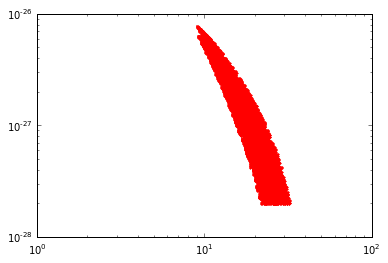

In [115]:
plt.loglog(pf.Chi_1,pf.z2_sigmav,'r.')

In [210]:
pff=pf

In [211]:
pff.shape

(8845, 233)

### Save extended DataFrame

In [112]:
pf.to_csv('pf.csv.bz2',compression='bz2')

#  Start analysis
<a id='analysis'></a>
##  Recover extended DataFrame

In [91]:
pff=pd.read_csv('pf.csv.bz2')
pff.shape

(36556, 201)

In [118]:
start=time.time()
pff['T_par_new_m']=stu.stumap_new(pff.MnINPUT.values,-pff.MDF.values,pff.lam.values,pff.tanb.values,vev=a.vev) #T is transpose
print 'Execution Time:',time.time()-start

Execution Time: 2.0162320137


### Main Columns
* `z_DD_SI`: Reescaled indirect detection cross section 

In [175]:
Omega_h2_EXP=np.array([0.1197-0.0044,0.1197,0.1197+0.0044])
LUX=multicurvefit()
AMS=multicurvefit()
LHC_cs=multicurvefit()
LHC_exc_cs=multicurvefit()
LUX.read_json('lux2016.json')
AMS.read_json('ID_max.json')
LHC_cs.read_json('SDFDM_cs.json')
LHC_exc_cs.read_json('SDFDM_exc_cs.json')

## Constraints
* $\Omega h^2\le(\Omega h^2)_{\text{Planck}}$, at one $\sigma$

To add to hep constants:

###  Main cuts exploration

In [212]:
pf=pff[pff.Omega_h2<Omega_h2_EXP[2]].reset_index(drop=True)
pfe=pff[pff.Omega_h2>Omega_h2_EXP[2]].reset_index(drop=True)
print pff.shape[0],np.abs(pff.Chi_1.min())
opf=Oh2(pff) #pf[ np.logical_and(pf.Omega_h2<Omega_h2_EXP[2],pf.Omega_h2>Omega_h2_EXP[0]) ].reset_index(drop=True)
print opf.shape

8845 8.99903836
(759, 233)


We vary the parameters as...

The parameter space is illustrated below whit the defined color conventions for points with too large relic density, proper relic density and small relic density

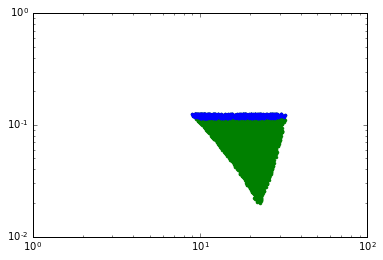

In [213]:
plt.loglog(pfe.Chi_1,pfe.Omega_h2,'r.')
plt.loglog(pf.Chi_1,pf.Omega_h2,'g.')
plt.loglog(opf.Chi_1,opf.Omega_h2,'b.')

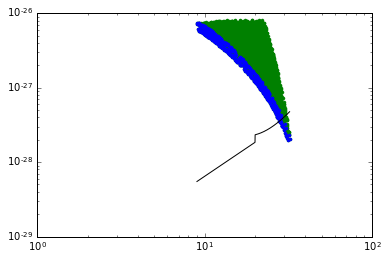

In [42]:
plt.loglog(pfe.Chi_1,pfe.sigmav,'r.')
plt.loglog(pf.Chi_1,pf.sigmav,'g.')
plt.loglog(opf.Chi_1,opf.sigmav,'b.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,'k-' )

(2.2, 400)

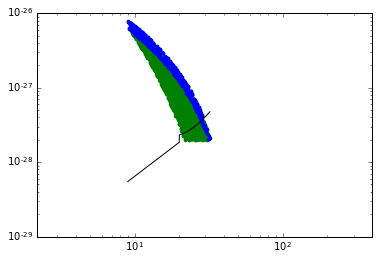

In [43]:
plt.loglog(pfe.Chi_1,pfe.z2_sigmav,'r.')
plt.loglog(pf.Chi_1,pf.z2_sigmav,'g.')
plt.loglog(opf.Chi_1,opf.z2_sigmav,'b.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,'k-' )
plt.loglog(pfe.Chi_1,pfe.AMS_ID_bb,'k-' )
plt.xlim(2.2,400)

(1e-30, 1e-26)

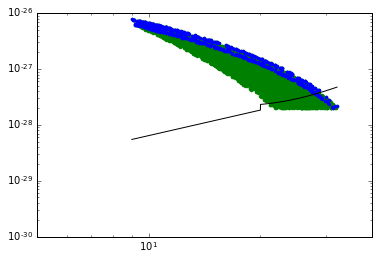

In [44]:
plt.loglog(pfe.Chi_1,pfe.z2_sigmav,'r.')
plt.loglog(pf.Chi_1,pf.z2_sigmav,'g.')
plt.loglog(opf.Chi_1,opf.z2_sigmav,'b.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,'k-' )
plt.xlim(5,40)
plt.ylim(1E-30,1E-26)

(1e-21, 0.0001)

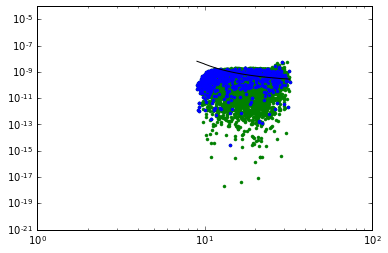

In [45]:
plt.loglog(pfe.Chi_1,pfe.z_DD_SI,'r.')
plt.loglog(pf.Chi_1,pf.z_DD_SI,'g.')
plt.loglog(opf.Chi_1,opf.z_DD_SI,'b.')
plt.loglog(pf.Chi_1,pf.lux_SI,'k-' )
plt.loglog(pfe.Chi_1,pfe.lux_SI,'k-' )
plt.ylim(1E-21,1E-4)

## Proposed cuts
* a: relic density 
* b: Electroweak precision tests
* c: $\operatorname{Br}_{\text{inv}}$
* d: $R_{\gamma\gamma}$
* e: Collider physics
* f: Direct detection
* g: Indirect detection

In [45]:
#def cuts(pf):
    cf=pd.Series()
    cf['a']=pf[pf.Omega_h2<=Omega_h2_EXP[2]]
    cf['b']=cf.a[cf.a['h0 ->  Chi_1 Chi_1']<0.19]
    cf['c']=cf.b[np.logical_and(cf.b['h0 ->  PHOT PHOT']/h_to_AA>R_AA[0],\
                                cf.b['h0 ->  PHOT PHOT']/h_to_AA<R_AA[2])]
    cf['d']=cf.c[cf.c.z_DD_SI<cf.c.lux_SI]
    cf['e']=cf.d[cf.d.LHC_cs_br<cf.d.LHC_exc_cs]
    cf['f']=cf.e[cf.e.T_par_new<0.2]
    return cf

SyntaxError: 'return' outside function (<ipython-input-45-de08909e3624>, line 10)

cuts_a_Omega_h2         True
cuts_all                True
cuts_b_Br_inv           True
cuts_c_R_gamma_gamma    True
cuts_d_z_DD             True
cuts_e_LHC              True
cuts_f_STU              True
dtype: bool

In [136]:

    print 1

In [214]:
nl=17
cf=pd.Series()
cf['full']=pffull
print '-'*nl
print '| All |', cf.full.shape[0],'  |'
cf['All']=pfall
print '-'*nl
print '| Reg |', cf.All.shape[0],'  |'
cf['a']=pff[pff.Omega_h2<=Omega_h2_EXP[2]]
print '-'*nl
print '| a   |', cf.a.shape[0],'  |'
cf['b']=cf.a[cf.a['h0 ->  Chi_1 Chi_1']<0.19]
print '-'*nl
print '| b   |', cf.b.shape[0],'  |'
cf['c']=cf.b[np.logical_and(cf.b['h0 ->  PHOT PHOT']/h_to_AA>R_AA[0],cf.b['h0 ->  PHOT PHOT']/h_to_AA<R_AA[2])]
print '-'*nl
print '| c   |', cf.c.shape[0],'  |'
cf['d']=cf.c[cf.c.z_DD_SI<cf.c.lux_SI]
print '-'*nl
print '| d   |', cf.d.shape[0],'   |'
cf['e']=cf.d[cf.d.LHC_cs_br<cf.d.LHC_exc_cs]
print '-'*nl
print '| e   |', cf.e.shape[0],'  |'
cf['f']=cf.e[cf.e.T_par_new<0.2]
print '-'*nl
print '| f   |', cf.f.shape[0],'  |'

-----------------
| All | 37065   |
-----------------
| Reg | 25175   |
-----------------
| a   | 8845   |
-----------------
| b   | 2353   |
-----------------
| c   | 2353   |
-----------------
| d   | 2353    |
-----------------
| e   | 2227   |
-----------------
| f   | 26   |


In [215]:
#cf.e.to_csv('not_T.csv',index=False)
#pf=pd.read_csv('selected_points.csv')

Check cuts:

In [181]:
cf.c[['MDF','LHC_cs_br','LHC_exc_cs']]

,MDF,LHC_cs_br,LHC_exc_cs
0,-110.290073,3.640655,1.530829
2,-100.484572,5.364617,2.011831
3,-105.728302,4.384665,1.732853
14,-110.359767,3.268869,1.527994
18,-103.883026,4.772297,1.824741
22,-114.544347,2.662673,1.437615
28,-100.236487,5.461244,2.026478
33,-108.511493,3.894145,1.605635
42,-111.950345,3.507479,1.465158
47,-125.552744,2.078238,1.411645


In [91]:
cf.All.shape

(25148, 233)

(0.78, 1.1)

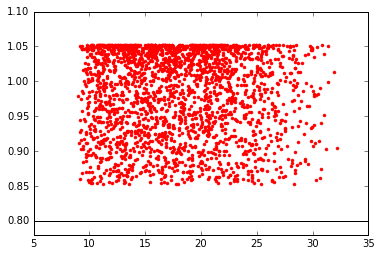

In [90]:
plt.plot(cf.b.Chi_1,cf.b['h0 ->  PHOT PHOT']/h_to_AA,'r.')
plt.hlines(R_AA[0],5,35)
plt.ylim(0.78,1.10)

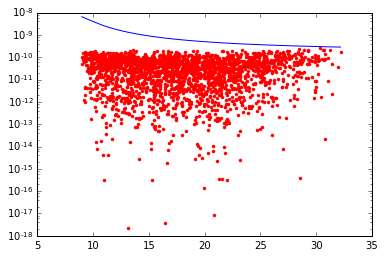

In [94]:
plt.semilogy(cf.c.Chi_1,cf.c.z_DD_SI,'r.')
plt.plot(cf.c.Chi_1,cf.c.lux_SI)

##  Parameter space after all cuts

(1e-29, 1e-25)

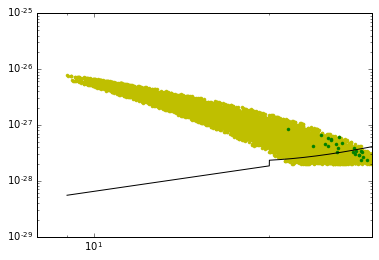

In [95]:
cut='f'
ocf=pd.Series()
#ocf[cut]=Oh2(cf[cut])
plt.loglog(pff.Chi_1,pff.z2_sigmav,'y.')
plt.loglog(cf[cut].Chi_1,cf[cut].z2_sigmav,'g.')
#plt.loglog(ocf[cut].Chi_1,ocf[cut].z2_sigmav,'b.')
#cut='b'
#ocf[cut]=Oh2(cf[cut])
#plt.loglog(cf[cut].Chi_1,cf[cut].z2_sigmav,'r.')
#plt.loglog(ocf[cut].Chi_1,ocf[cut].z2_sigmav,'c.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,'k-' )
plt.loglog(pfe.Chi_1,pfe.AMS_ID_bb,'k-' )
plt.xlim(2.2,400)
plt.xlim(8.,30)
plt.ylim(1E-29,1E-25)

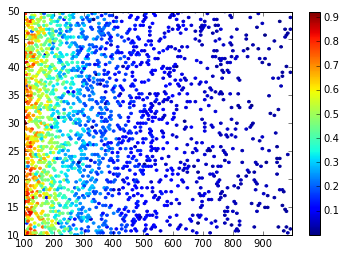

In [96]:
cut='full'
cfl=cf[cut][np.logical_and(cf[cut].lam>0.9,cf[cut].lam<1.1)]
plt.hexbin(cfl.MDF.abs(),cfl.MnINPUT,cfl.T_par_new,xscale='lin',yscale='lin')#,norm=LogNorm(),gridsize = 100)
plt.colorbar()

(10, 50)

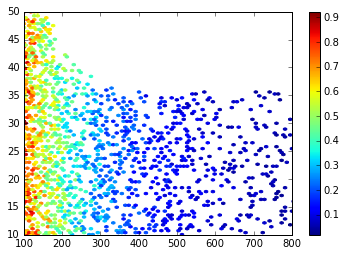

In [113]:
cut='All'
cfl=cf[cut][np.logical_and(cf[cut].lam>0.9,cf[cut].lam<1.1)]
plt.hexbin(cfl.MDF.abs(),cfl.MnINPUT,cfl.T_par_new,xscale='lin',yscale='lin')#,norm=LogNorm(),gridsize = 100)
plt.colorbar()
plt.xlim(100,800)
plt.ylim(10,50)

(10, 50)

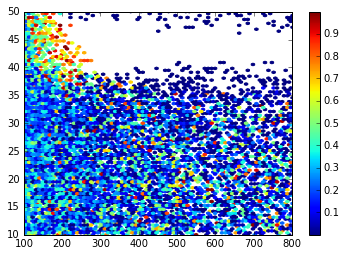

In [112]:
cut='All'
cfl=cf[cut][cf[cut].T_par_new<1]#[np.logical_and(cf[cut].lam>0.9,cf[cut].lam<1.1)]
plt.hexbin(cfl.MDF.abs(),cfl.MnINPUT,cfl.T_par_new,xscale='lin',yscale='lin')#,norm=LogNorm(),gridsize = 100)
plt.colorbar()
plt.xlim(100,800)
plt.ylim(10,50)

(10, 50)

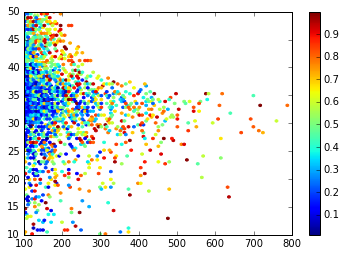

In [121]:
cut='a'
cfl=cf[cut][cf[cut].T_par_new<1]#[np.logical_and(cf[cut].lam>0.9,cf[cut].lam<1.1)]
plt.hexbin(cfl.MDF.abs(),cfl.MnINPUT,cfl.T_par_new,xscale='lin',yscale='lin')#,norm=LogNorm(),gridsize = 100)
plt.colorbar()
plt.xlim(100,800)
plt.ylim(10,50)

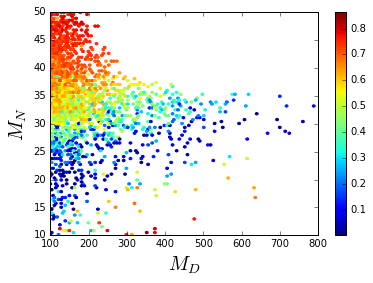

In [124]:
plt.hexbin(cfl.MDF.abs(),cfl.MnINPUT,cfl['h0 ->  Chi_1 Chi_1'],xscale='lin',yscale='lin')#,norm=LogNorm(),gridsize = 100)
plt.colorbar()
plt.xlim(100,800)
plt.ylim(10,50)
plt.xlabel('$M_D$',size=20)
plt.ylabel('$M_N$',size=20)

(10, 50)

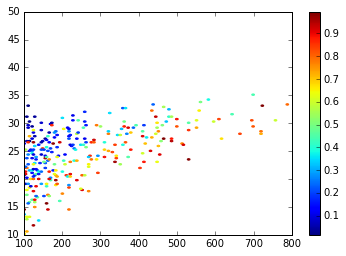

In [110]:
cut='b'
cfl=cf[cut][cf[cut].T_par_new<1]#[np.logical_and(cf[cut].lam>0.9,cf[cut].lam<1.1)]
plt.hexbin(cfl.MDF.abs(),cfl.MnINPUT,cfl.T_par_new,xscale='lin',yscale='lin')#,norm=LogNorm())#,gridsize = 100)
plt.colorbar()
plt.xlim(100,800)
plt.ylim(10,50)

(10, 50)

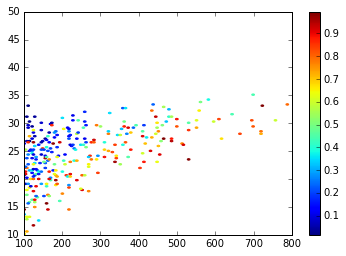

In [109]:
cut='c'
cfl=cf[cut][cf[cut].T_par_new<1]#[np.logical_and(cf[cut].lam>0.9,cf[cut].lam<1.1)]
plt.hexbin(cfl.MDF.abs(),cfl.MnINPUT,cfl.T_par_new,xscale='lin',yscale='lin')#,norm=LogNorm())#,gridsize = 100)
plt.colorbar()
plt.xlim(100,800)
plt.ylim(10,50)

(10, 50)

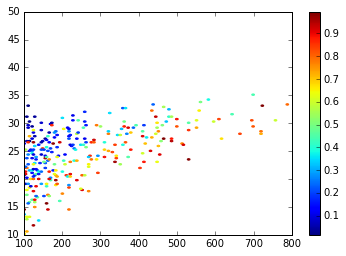

In [108]:
cut='d'
cfl=cf[cut][cf[cut].T_par_new<1]#[np.logical_and(cf[cut].lam>0.9,cf[cut].lam<1.1)]
plt.hexbin(cfl.MDF.abs(),cfl.MnINPUT,cfl.T_par_new,xscale='lin',yscale='lin')#,norm=LogNorm())#,gridsize = 100)
plt.colorbar()
plt.xlim(100,800)
plt.ylim(10,50)

(10, 50)

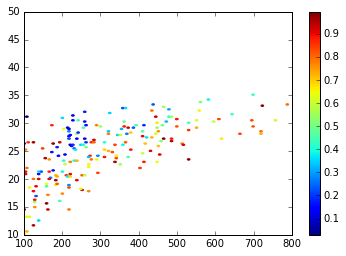

In [107]:
cut='e'
cfl=cf[cut][cf[cut].T_par_new<1]#[np.logical_and(cf[cut].lam>0.9,cf[cut].lam<1.1)]
plt.hexbin(cfl.MDF.abs(),cfl.MnINPUT,cfl.T_par_new,xscale='lin',yscale='lin')#,norm=LogNorm())#,gridsize = 100)
plt.colorbar()
plt.xlim(100,800)
plt.ylim(10,50)

(10, 35)

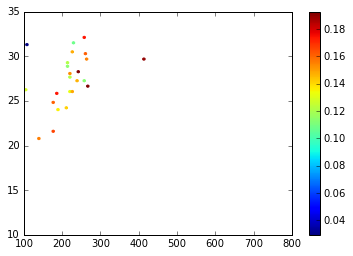

In [103]:
cut='f'
cfl=cf[cut][cf[cut].T_par_new<1]#[np.logical_and(cf[cut].lam>0.9,cf[cut].lam<1.1)]
plt.hexbin(cfl.MDF.abs(),cfl.MnINPUT,cfl.T_par_new,xscale='lin',yscale='lin',gridsize=50)#,norm=LogNorm())#,gridsize = 100)
plt.colorbar()
plt.xlim(100,800)
plt.ylim(10,35)

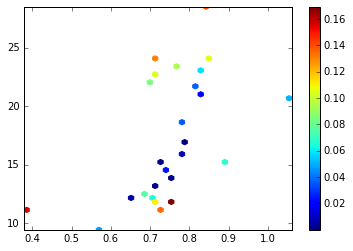

In [119]:
cut='f'
cfl=cf[cut][cf[cut].T_par_new<1]#[np.logical_and(cf[cut].lam>0.9,cf[cut].lam<1.1)]
plt.hexbin(cfl.lam,cfl.tanb,cfl['h0 ->  Chi_1 Chi_1'],xscale='lin',yscale='lin',gridsize=50)#,norm=LogNorm())#,gridsize = 100)
plt.colorbar()

(1e-29, 1e-25)

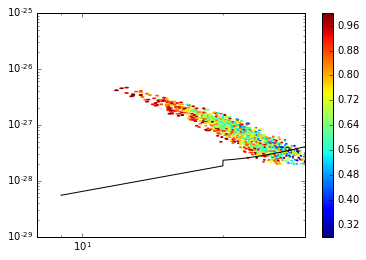

In [68]:
cut='a'
cf[cut]=cf[cut][cf[cut].z2_sigmav>0]
cfp=cf[cut][np.logical_and(cf[cut].lam<1.,cf[cut].Chi_1<50)]
cfp=cfp[cfp.MDF<200]
#plt.loglog(cf[cut].Chi_1,cf[cut].z2_sigmav,'c.')
plt.hexbin(cfp.Chi_1,cfp.z2_sigmav,cfp.lam,xscale='lin',yscale='log')
plt.colorbar()
plt.loglog(pff.Chi_1,pff.AMS_ID_bb,'k-' )
plt.xlim(8.,30)
plt.ylim(1E-29,1E-25)

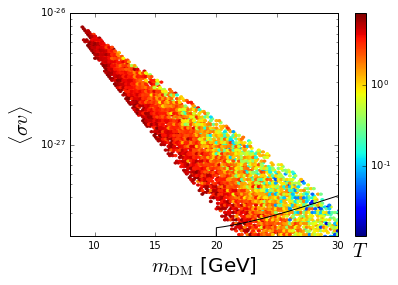

In [69]:
cut='a'
#cf[cut]=cf[cut][cf[cut].z2_sigmav>0]
cfp=cf[cut][cf[cut].T_par_new<10]#[np.logical_and(cf[cut].lam<1.,cf[cut].Chi_1<50)]
#cfp=cfp[cfp.MDF<200]
#plt.loglog(cf[cut].Chi_1,cf[cut].z2_sigmav,'c.')
plt.hexbin(cfp.Chi_1,cfp.z2_sigmav,cfp.T_par_new,xscale='lin',yscale='log',norm=LogNorm(),gridsize = 100)
pltc=plt.colorbar()
plt.semilogy(pff.Chi_1,pff.AMS_ID_bb,'k-' )
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
pltc.ax.set_xlabel('$T$',size=20)
plt.xlim(8.,30)
plt.ylim(2E-28,1E-26)
plt.savefig('T.pdf')

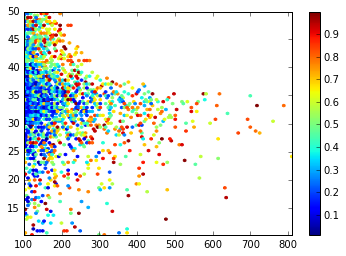

In [62]:
cfp=cf[cut][cf[cut].T_par_new<1]
plt.hexbin(-cfp.MDF,cfp.MnINPUT,cfp.T_par_new,xscale='lin',yscale='lin')#,norm=LogNorm(),gridsize = 100)
plt.colorbar()

(1e-28, 3e-27)

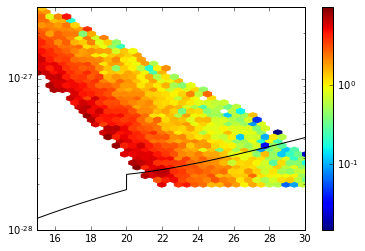

In [52]:
cut='a'
#cf[cut]=cf[cut][cf[cut].z2_sigmav>0]
cfp=cf[cut]#[np.logical_and(cf[cut].lam<1.,cf[cut].Chi_1<50)]
#cfp=cfp[cfp.MDF<200]
#plt.loglog(cf[cut].Chi_1,cf[cut].z2_sigmav,'c.')
plt.hexbin(cfp.Chi_1,cfp.z2_sigmav,cfp.T_par,xscale='lin',yscale='log',norm=LogNorm(),gridsize = 50)
plt.colorbar()
plt.semilogy(pff.Chi_1,pff.AMS_ID_bb,'k-' )
plt.xlim(15.,30)
plt.ylim(1E-28,3E-27)

(1e-28, 1e-26)

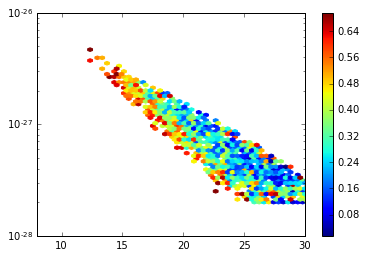

In [53]:
cfp=cfp[cfp.T_par<0.7]
plt.hexbin(cfp.Chi_1,cfp.z2_sigmav,cfp.T_par,xscale='lin',yscale='log',gridsize = 50)#,norm=LogNorm())
plt.colorbar()
plt.xlim(8.,30)
plt.ylim(1E-28,1E-26)

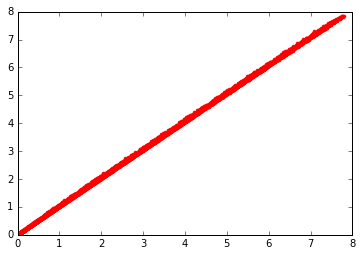

In [54]:
plt.plot(pf.T_par_new,pf.T_par_new_m,'r.')

In [71]:
ncf=pd.Series()
for cut in 'abcdef':
    ncf[cut]=cf[cut][cf[cut].z2_sigmav>cf[cut].AMS_ID_bb]

(1e-29, 1e-25)

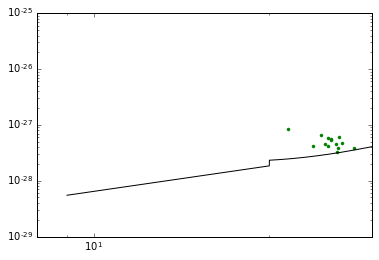

In [72]:
cut='f'
plt.loglog(ncf[cut].Chi_1,ncf[cut].z2_sigmav,'g.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,'k-' )
plt.loglog(pfe.Chi_1,pfe.AMS_ID_bb,'k-' )
plt.xlim(8.,30)
plt.ylim(1E-29,1E-25)

In [74]:
ncf.f.tanb

17660    12.071683
19894     9.422859
20611    21.698382
21055    11.195130
21256    13.321381
21299    28.497927
21506    23.495754
21565    14.505097
22063    16.974790
22116    13.742001
22256    12.071276
22307    24.215051
22588    22.024244
23600    15.811360
Name: tanb, dtype: float64

In [75]:
zz.z2_sigmav.max()

NameError: name 'zz' is not defined

In [77]:
zz=ncf.f.reset_index(drop=True)
pz=pd.DataFrame()
for i in range(zz.shape[0]):
        ps=pd.Series()
        mdf=zz.ix[i].MDF
        MnINPUT=zz.ix[i].MnINPUT
        lam=zz.ix[i].lam
        tanb=zz.ix[i].tanb
        lu=lam*np.sin(np.arctan(tanb))
        ld=lam*np.cos(np.arctan(tanb))
        devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
        a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
        a.LHA.blocks['MINPAR'][2]='%0.8E       # MDF' %mdf
        a.LHA.blocks['MINPAR'][3]='%0.8E       # MnINPUT' %MnINPUT
        a.LHA.blocks['MINPAR'][4]='%0.8E       # lamuINPUT' %lu
        a.LHA.blocks['MINPAR'][5]='%0.8E       # lamdINPUT' %ld
        moc=a.runmicromegas(Direct_Detection=True)
        #print 'Omega h^2, SI proton, neutron, MChi =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI,\
        a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
    #manual pdgs:
        a.pdg['Frep']=-210000601
        a.branchings(a.LHA_out.decays,min_pdg=23)
        #print 'Omega h^2, SI proton, sigmav,Br_inv  =',mo.Omega_h2,mo.proton.SI,mo.sigmav,a.Br_names['h0 ->  Chi_1 Chi_1']
        #print a.Br_names['Fre ->  Chi_1 W-'],a.Br_names['Cha.Seriesi_2 ->  Chi_1 Z0']
        a.Series['sigma_chi0_chipm']=0.3 #pb from fig. 15 of arXiv:1411.1335
        a.Series['Chi_1']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
        a.Series['Chi_2']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_2]
        a.Series['Chi_3']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_3]
        a.Series['Fre']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Fre]
        ps=ps.append(a.Series)
        ps=ps.append(a.Br_names)
        #ps=ps.append(  mo.rename( {'Omega_h2':'Omega_h2_mo','proton_SI':'proton_SI_mo','neutron_SI':'neutron_SI_mo',\
        #                           'proton_SD':'proton_SD_mo','neutron_SD':'neutron_SD_mo','sigmav':'sigmav_mo',\
        #                             } )  )
        pz=pz.append(ps,ignore_index=True)
        pz=pz.fillna(0)

In [78]:
pz.Gamma_Z0*pz['Z0 ->  Chi_1 Chi_1']

0     0.019287
1     0.025296
2     0.008475
3     0.011557
4     0.011532
5     0.007348
6     0.007120
7     0.007327
8     0.007364
9     0.010539
10    0.008210
11    0.005940
12    0.005436
13    0.005229
dtype: float64

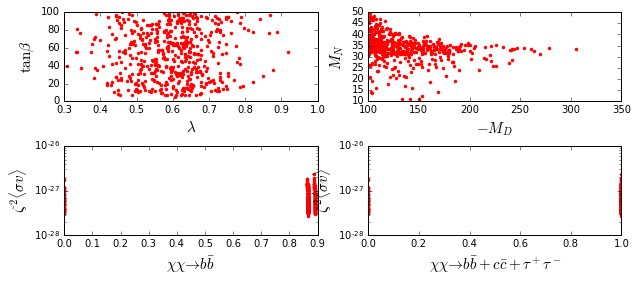

In [57]:
spf=ncf.b
#fig, axes = plt.subplots(nrows=2, ncols=2)
#fig.tight_layout()
fig=plt.figure()
fig.subplots_adjust(hspace=0.5,wspace=0.2,left=0.01,right=1.3)
fig.add_subplot(221)
plt.plot(spf['lambda'],spf.tanb,'r.')
plt.xlabel(r'$\lambda$',size=15)
plt.ylabel(r'$\tan\beta$',size=15)
fig.add_subplot(222)
plt.plot(-spf.MDF,spf.MnINPUT,'r.')
plt.xlabel(r'$-M_D$',size=15)
plt.ylabel(r'$M_N$',size=15)
fig.add_subplot(223)
plt.semilogy(spf['ID_br:~Chi1,~Chi1 -> d3 D3'],spf.z2_sigmav,'r.')
plt.xlabel(r'$\chi\chi\to b\bar{b}$',size=15)
plt.ylabel(r'$\zeta^2\langle\sigma v\rangle$',size=15)
fig.add_subplot(224)
plt.semilogy(spf['ID_br:~Chi1,~Chi1 -> d3 D3']+spf['ID_br:~Chi1,~Chi1 -> u2 U2']+spf['ID_br:~Chi1,~Chi1 -> e3 E3'],spf.z2_sigmav,'r.')
plt.xlabel(r'$\chi\chi\to b\bar{b}+c \bar{c}+\tau^+\tau^-$',size=15)
plt.ylabel(r'$\zeta^2\langle\sigma v\rangle$',size=15)

### Final scan

In [ ]:
start=time.time()
if 1==1:#if scan and not IGNORE_CELL:
    pf=pd.DataFrame()
    fulld=pd.DataFrame()
    v=a.vev
    #lambda_1=0.13
    mdf=-200; MN=40; tanb=100.;lam=0.35
    npoints=10000
    i=0;j=0
    for mdf in -np.logspace(np.log10(100),np.log10(300),npoints):
        i=i+1
        if i%1000==0: print i
        ps=pd.Series()
        MN=np.random.uniform(10,50)
        tanb=np.random.uniform(5,100)
        lam=np.random.uniform(0.1,1)
        lu=lam*np.sin(np.arctan(tanb))
        ld=lam*np.cos(np.arctan(tanb))
        devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
        a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
        a.LHA.blocks['MINPAR'][2]='%0.8E       # MDF' %mdf
        a.LHA.blocks['MINPAR'][3]='%0.8E       # MnINPUT' %MN
        a.LHA.blocks['MINPAR'][4]='%0.8E       # lamuINPUT' %lu
        a.LHA.blocks['MINPAR'][5]='%0.8E       # lamdINPUT' %ld
        moc=a.runmicromegas(Direct_Detection=True)
        #print 'Omega h^2, SI proton, neutron, MChi =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI,\
        a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
    #manual pdgs:
        a.pdg['Frep']=-210000601
        #mof=run_feynrules_SDFDM(MDF = -a.Series.MDF,MN = a.Series.MnINPUT,\
        #                    lu = a.Series.lamuINPUT,ld = a.Series.lamdINPUT ,v=a.vev)
    #implement sigma_v
        #mo=a.micromegas_output(mof['Full'])
        a.branchings(a.LHA_out.decays,min_pdg=25)
        #print 'Omega h^2, SI proton, sigmav,Br_inv  =',mo.Omega_h2,mo.proton.SI,mo.sigmav,a.Br_names['h0 ->  Chi_1 Chi_1']
        #print a.Br_names['Fre ->  Chi_1 W-'],a.Br_names['Cha.Seriesi_2 ->  Chi_1 Z0']
        a.Series['sigma_chi0_chipm']=0.3 #pb from fig. 15 of arXiv:1411.1335
        a.Series['Chi_1']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
        a.Series['Chi_2']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_2]
        a.Series['Chi_3']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_3]
        a.Series['Fre']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Fre]
        ps=ps.append(a.Series)
        ps=ps.append(a.Br_names)
        #ps=ps.append(  mo.rename( {'Omega_h2':'Omega_h2_mo','proton_SI':'proton_SI_mo','neutron_SI':'neutron_SI_mo',\
        #                           'proton_SD':'proton_SD_mo','neutron_SD':'neutron_SD_mo','sigmav':'sigmav_mo',\
        #                             } )  )
        C1=ps.Omega_h2<Omega_h2_EXP[2]
        C2=stu.stumap(ps.MnINPUT,ps.MDF,np.sqrt(ps.lamuINPUT**2+ps.lamdINPUT**2),ps.lamuINPUT/ps.lamdINPUT,vev=a.vev)<0.2 
        C3=ps.Omega_h2**2/Omega_h2_EXP[1]**2*ps.sigmav>2E-28
        if C1 and C2 and C3:
            pf=pf.append(ps,ignore_index=True)
            pf=pf.fillna(0)
            j=j+1
            print 'candidate:',j
        #Full backup of data: WARNING: HUGE File
        

pf.to_csv('scan_full_5.csv')
stop=time.time()
trun=stop-start
pd.DataFrame({'t':[trun]}).to_csv('trun.csv',index=False)

candidate: 1
candidate: 2
candidate: 3
candidate: 4
candidate: 5
candidate: 6
candidate: 7
candidate: 8
candidate: 9
candidate: 10
candidate: 11
candidate: 12
candidate: 13
candidate: 14
candidate: 15
candidate: 16
candidate: 17
candidate: 18
candidate: 19
candidate: 20
candidate: 21
candidate: 22
candidate: 23
candidate: 24
candidate: 25
candidate: 26
candidate: 27
candidate: 28
candidate: 29
candidate: 30
candidate: 31
candidate: 32
candidate: 33
candidate: 34
candidate: 35
candidate: 36
candidate: 37
candidate: 38
candidate: 39
candidate: 40
candidate: 41
candidate: 42
candidate: 43
candidate: 44
candidate: 45
candidate: 46
candidate: 47
candidate: 48
candidate: 49
candidate: 50
candidate: 51
candidate: 52
candidate: 53
candidate: 54
candidate: 55
candidate: 56
candidate: 57
candidate: 58
candidate: 59
candidate: 60
candidate: 61
candidate: 62
candidate: 63
candidate: 64
candidate: 65
candidate: 66
candidate: 67
candidate: 68
candidate: 69
candidate: 70
candidate: 71
candidate: 72
c

/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:321: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


candidate: 174
candidate: 175
candidate: 176
candidate: 177
candidate: 178
candidate: 179
candidate: 180
candidate: 181
candidate: 182
candidate: 183
candidate: 184
candidate: 185
candidate: 186
candidate: 187
candidate: 188
candidate: 189
candidate: 190
candidate: 191
candidate: 192
candidate: 193
candidate: 194
candidate: 195
candidate: 196
candidate: 197
candidate: 198
candidate: 199
candidate: 200
candidate: 201
candidate: 202
2000
candidate: 203
candidate: 204
candidate: 205
candidate: 206
candidate: 207
candidate: 208
candidate: 209
candidate: 210
candidate: 211
candidate: 212
candidate: 213
candidate: 214
candidate: 215
candidate: 216
candidate: 217
candidate: 218
candidate: 219
candidate: 220
candidate: 221
candidate: 222
candidate: 223
candidate: 224
candidate: 225
candidate: 226
candidate: 227
candidate: 228
candidate: 229
candidate: 230
candidate: 231
candidate: 232
candidate: 233
candidate: 234
candidate: 235
candidate: 236
candidate: 237
candidate: 238
candidate: 239
candi

In [38]:
aa=pd.read_csv('scan_full_5.csv')


In [40]:
cut='g'
ncf['g']=aa
plt.loglog(ncf[cut].Chi_1,ncf[cut].z2_sigmav,'g.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,'k-' )
plt.loglog(pfe.Chi_1,pfe.AMS_ID_bb,'k-' )
plt.xlim(8.,30)
plt.ylim(1E-29,1E-25)

AttributeError: 'DataFrame' object has no attribute 'z2_sigmav'

4.0652608966024086e-28

In [309]:
25429./60./60.

7.063611111111111

Check SARAH calcultation of $h\to \gamma\gamma$

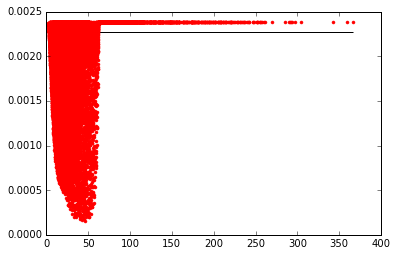

In [174]:
plt.plot(pff.Chi_1,pff['h0 ->  PHOT PHOT'],'r.')
plt.hlines(h_to_AA,pff.Chi_1.min(),pff.Chi_1.max())

* Collider constraints (check large mixing points with prospino)

In [79]:
cpf=hpf[hpf.LHC_cs_br<hpf.LHC_exc_cs]
cpf.shape

(7697, 201)

* STU constraints

* Indirect detection: $\langle\sigma v\rangle$

We will use arXiv:1504.04276 $\chi\overline{\chi}\to b\bar{b}$ constrains with Ein MAX profile frpm AMS-02

In [29]:
spf=lpf[lpf.z2_sigmav<lpf.AMS_ID_bb]
print spf.shape[0]

4623


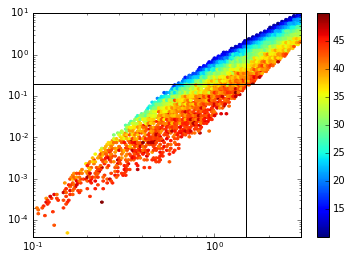

In [218]:
chimax=50
plt.hexbin(pf[pf.Chi_1<chimax].lam,pf[pf.Chi_1<chimax].T_par,pf[pf.Chi_1<chimax].Chi_1,yscale='log',xscale='log')
plt.hlines(0.2,0.1,3)
plt.vlines(1.5,4E-5,10)
plt.colorbar()

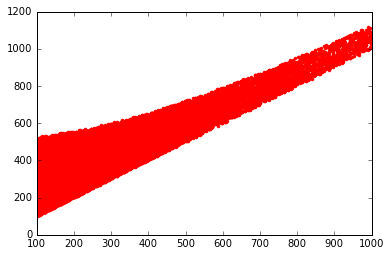

In [33]:
plt.plot(np.abs(pf.MDF),np.abs(pf.Chi_2),'r.')

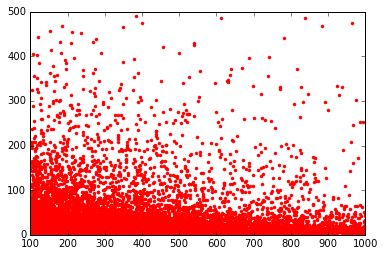

In [36]:
plt.plot(np.abs(pf.MDF),pf.lamdINPUT*a.vev,'r.')

TODO: The constraints in 1411.1335 are in the pure Higgsino limit. The quoted cross section is for either $\chi_2$ or $\chi_3$. 

I must:
* Use prospino to calculate the cross section for point wiht high mixing: $\lambda_{u,d}v\sim MD$
* Filter point not satisfying STU constraints

* Spin independent direct detection  LUX

In [77]:
lpf=pf[pf.z_DD_SI<pf.lux_SI]
print lpf.shape[0]

19071


* Invisible decay from LHC

In [78]:
hpf=lpf[lpf['h0 ->  Chi_1 Chi_1']<0.19]
hpf.shape

(8013, 201)

* Collider constraints (check large mixing points with prospino)

In [79]:
cpf=hpf[hpf.LHC_cs_br<hpf.LHC_exc_cs]
cpf.shape

(7697, 201)

* STU constraints

* Indirect detection: $\langle\sigma v\rangle$

We will use arXiv:1504.04276 $\chi\overline{\chi}\to b\bar{b}$ constrains with Ein MAX profile frpm AMS-02

In [29]:
spf=lpf[lpf.z2_sigmav<lpf.AMS_ID_bb]
print spf.shape[0]

4623


Points with rescaled relic density less than the Planck value

(7.1992306880000001, 366.50992100000002)

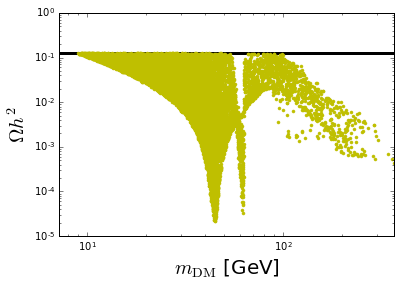

In [80]:
plt.loglog(pf.Chi_1,pf.Omega_h2,'y.')
plt.hlines(Omega_h2_EXP[2],1,1000,lw=3)#np.abs(pf.Chi_1).min(),np.abs(pf.Chi_1).max())
plt.ylabel(r'$\Omega h^2$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.xlim(np.abs(pf.Chi_1).min()*0.8,np.abs(pf.Chi_1).max())

Points with rescaled relic density less than the Planck value in the $\langle\sigma v\rangle$-$m_{\rm DM}$ plane

Blue line: xcluded region from 1504.04276 for $\chi\overline{\chi}\to b\overline{b}$ channel

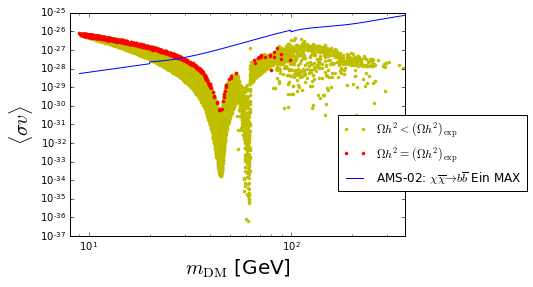

In [81]:
plt.loglog(pf.Chi_1,pf.z2_sigmav,'y.',label=r'$\Omega h^2<(\Omega h^2)_{\rm exp}$')
plt.loglog(opf.Chi_1,opf.z2_sigmav,'r.',label=r'$\Omega h^2=(\Omega h^2)_{\rm exp}$')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,label=r'AMS-02: $\chi\overline{\chi}\to b\overline{b}$ Ein MAX')
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.legend(loc=(0.8,0.2))

rescaled direct detection constraint from LUX

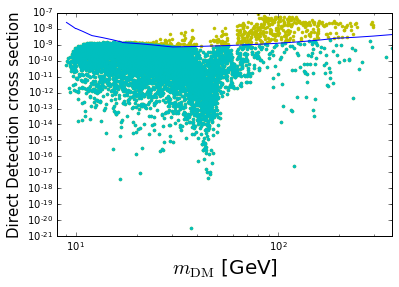

In [32]:
plt.loglog(pf.Chi_1,pf.z_DD_SI,'y.')
plt.loglog(lpf.Chi_1,lpf.z_DD_SI,'c.')
plt.loglog(pf.Chi_1,pf.lux_SI)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'Direct Detection cross section',size=15)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)

Points which pass the rescaled direct detection constraint from LUX

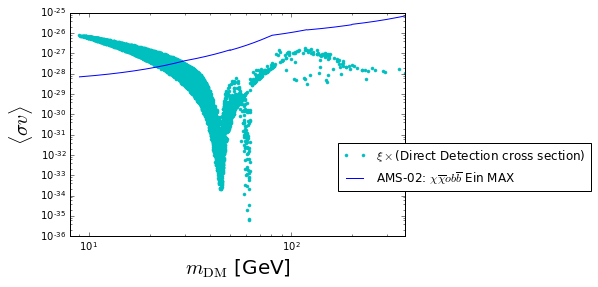

In [33]:
plt.loglog(lpf.Chi_1,lpf.z2_sigmav,'c.',label=r'$\xi\times $(Direct Detection cross section)')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,label='AMS-02: $\chi\overline{\chi}\to b\overline{b}$ Ein MAX')
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.legend(loc=(0.8,0.2))

Points which pass the Higgs invisible decay  constraint from LHC: Br$(h\to \chi\overline{\chi})<0.19$

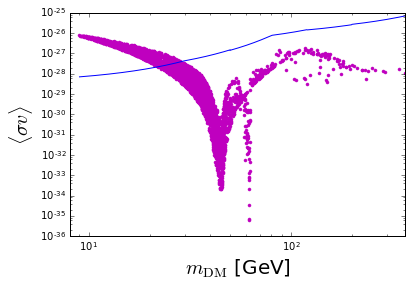

In [34]:
plt.loglog(hpf.Chi_1,hpf.z2_sigmav,'m.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)

Points which pass the $R_{\gamma\gamma}$ constraint from LHC:

In [108]:
hpf.shape

(3203, 148)

In [109]:
haapf=hpf[np.logical_and(hpf['h0 ->  PHOT PHOT']/h_to_AA>R_AA[0],hpf['h0 ->  PHOT PHOT']/h_to_AA<R_AA[2])]
haapf.shape

(2812, 148)

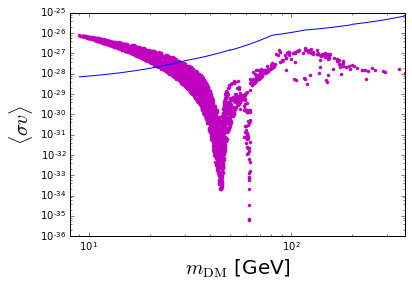

In [107]:
plt.loglog(haapf.Chi_1,haapf.z2_sigmav,'m.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)

In [25]:
A(100,100)

-0.26745094704783295

In [443]:
start=time.time()
p=0
q=0
for i in range(3):
    p=p+V[0,i]**2*At()[3,i]+V[1,i]**2*At(minus=True)[3,i]
    for j in range(3):
            q=q+V[0,i]*V[0,i]*At(minus=True)[i,j]*V[1,j]*V[1,j]\
               +V[1,i]*V[1,i]*At(minus=True)[i,j]*V[0,j]*V[0,j]\
               +V[0,i]*V[1,i]*At(minus=True)[i,j]*V[0,j]*V[1,j]
print p
print q
print time.time()-start

1.70005588443
4.04723492684
0.00122284889221


In [448]:
start=time.time()

print p
print q
print time.time()-start

1.70005588443
4.04723492684
0.000939130783081


In [421]:
V[1,:]*V[1,:]

array([ 0.89866134,  0.        ,  0.10133866])

In [422]:
V

array([[ 0.        ,  1.        ,  0.        ],
       [-0.9479775 ,  0.        , -0.31833734],
       [ 0.31833734,  0.        , -0.9479775 ]])

In [398]:
At(minus=True)

array([[  6.69396367e+01,   2.31158157e-01,   1.63856483e+02],
       [  2.31158157e-01,   8.35199955e+01,   1.79189709e+01],
       [  1.63856483e+02,   1.79189709e+01,   3.08712761e+02],
       [  2.31158157e-01,   8.35199955e+01,   1.79189709e+01]])

In [326]:
At

array([[  -0.25842812,   74.13054529,   22.2118656 ],
       [  74.13054529,   -0.32356158,  176.25578452],
       [  22.2118656 ,  176.25578452,   -1.22110354],
       [  74.13054529,   -0.32356158,  176.25578452]])

In [330]:
At

array([  22.2118656 ,  176.25578452,   -1.22110354,  176.25578452])

In [387]:
At=Atilde(MDF,m)

In [388]:
At[1,'-:']

va1 (1, '-:')
va 1


array([  0.23115816,  83.51999555,  17.9189709 ])

In [389]:
At[1,:]

va1 (1, slice(None, None, None))


array([  74.13054529,   -0.32356158,  176.25578452])

In [380]:
Atm=np.array( [ [A(m[0],-m[0]),A(m[0],-m[1]),A(m[0],-m[2])],
                                [A(m[1],-m[0]),A(m[1],-m[1]),A(m[1],-m[2])],
                                [A(m[2],-m[0]),A(m[2],-m[1]),A(m[2],-m[2])],
                                [A(MDF, -m[0]),A(MDF, -m[1]),A(MDF, -m[2])]])

In [381]:
Atm[1,:]

array([  0.23115816,  83.51999555,  17.9189709 ])

In [217]:
#%%writefile stu1.py
x1['V11']=1./np.sqrt(2)*(-x1['N12']+x1['N13'])
x1['V21']=1./np.sqrt(2)*(-x1['N22']+x1['N33'])
x1['V31']=1./np.sqrt(2)*(-x1['N32']+x1['N33'])

x1['V12']=1./np.sqrt(2)*(x1['N12']+x1['N13'])
x1['V22']=1./np.sqrt(2)*(x1['N22']+x1['N33'])
x1['V32']=1./np.sqrt(2)*(x1['N32']+x1['N33'])

#Warning in the squared root
x1['V13']=1./np.sqrt(2)*x1['N11']
x1['V23']=1./np.sqrt(2)*x1['N21']
x1['V33']=1./np.sqrt(2)*x1['N31']

$\Pi(0)$ and $\Pi(0)'$ : http://arxiv.org/abs/0705.4493

In [243]:
#%%writefile stu2.py
v=a.vev

x1['T_par']=x1['V11']**2*A(x1['MDF'],x1['Mchi1'])\
            +x1['V12']**2*A(x1['MDF'],x1['Mchi2'])\
            +x1['V13']**2*A(x1['MDF'],x1['Mchi3'])\
            +x1['V21']**2*A(x1['MDF'],-x1['Mchi1'])\
            +x1['V22']**2*A(x1['MDF'],-x1['Mchi2'])\
            +x1['V23']**2*A(x1['MDF'],-x1['Mchi3'])\
            -1./2*(x1['V11']*x1['V21']+x1['V21']*x1['V11'])**2*A(x1['Mchi1'],-x1['Mchi1'])\
            -1./2*(x1['V11']*x1['V22']+x1['V21']*x1['V12'])**2*A(x1['Mchi1'],-x1['Mchi2'])\
            -1./2*(x1['V11']*x1['V23']+x1['V21']*x1['V13'])**2*A(x1['Mchi1'],-x1['Mchi3'])\
            -1./2*(x1['V12']*x1['V21']+x1['V22']*x1['V11'])**2*A(x1['Mchi2'],-x1['Mchi1'])\
            -1./2*(x1['V12']*x1['V22']+x1['V22']*x1['V12'])**2*A(x1['Mchi2'],-x1['Mchi2'])\
            -1./2*(x1['V12']*x1['V23']+x1['V22']*x1['V13'])**2*A(x1['Mchi2'],-x1['Mchi3'])\
            -1./2*(x1['V13']*x1['V21']+x1['V23']*x1['V11'])**2*A(x1['Mchi3'],-x1['Mchi1'])\
            -1./2*(x1['V13']*x1['V22']+x1['V23']*x1['V12'])**2*A(x1['Mchi3'],-x1['Mchi2'])\
            -1./2*(x1['V13']*x1['V23']+x1['V23']*x1['V13'])**2*A(x1['Mchi3'],-x1['Mchi3'])\

In [244]:
lu = 0.1;ld = 0.1
lam=np.sqrt(lu**2+ld**2)
tanb=lu/ld
stu.stumap(101.,110.,lam,tanb)

4.6220999152247066e-16

In [245]:
x1.T_par

78.43672114679228

In [223]:
stu.stumap?

Points which pass the collider constraints from LHC

In [113]:
expf=haapf[haapf.LHC_cs_br>haapf.LHC_exc_cs]
expf.shape

(122, 148)

In [36]:
1+1

2

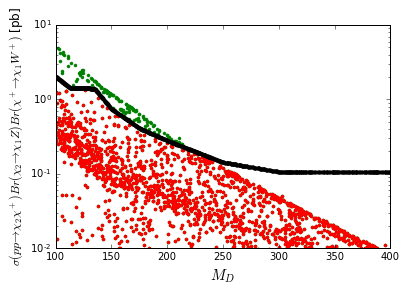

In [114]:
plt.semilogy(np.abs(hpf.MDF),hpf.LHC_cs_br,'g.')
#plt.semilogy(np.abs(expf.MDF),expf.LHC_cs_br,'b.')
plt.semilogy(np.abs(cpf.MDF),cpf.LHC_cs_br,'r.')
plt.semilogy(np.abs(cpf.MDF),cpf.LHC_exc_cs,'k.')
plt.xlim(100,400)
plt.ylim(0.01,10)
plt.xlabel(r'$M_D$',size=15)
plt.ylabel(r'$\sigma(pp\to \chi_2 \chi^+){Br}(\chi_2\to \chi_1 Z){Br}(\chi^+\to \chi_1 W^+)$ [pb]',size=12 )

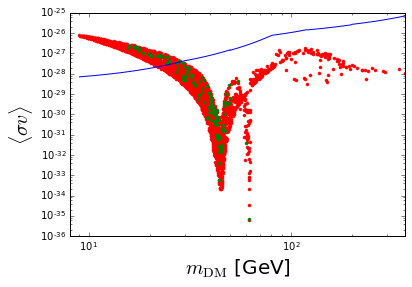

In [115]:
plt.loglog(cpf.Chi_1,cpf.z2_sigmav,'r.')
plt.loglog(expf.Chi_1,expf.z2_sigmav,'g.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)

In [39]:
idb=pd.read_csv('ID_best.dat',header=None)
idb=idb.rename(columns={0:'MDF',1:'sigmav'})

In [40]:
idm=pd.read_csv('ID_med.dat',header=None)
idm=idm.rename(columns={0:'MDF',1:'sigmav'})

(1e-29, 1e-25)

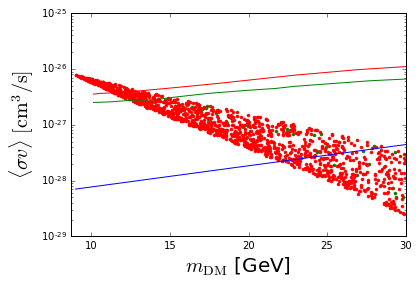

In [41]:
plt.semilogy(expf.Chi_1,expf.z2_sigmav,'g.')
plt.semilogy(cpf.Chi_1,cpf.z2_sigmav,'r.')
plt.semilogy(pf.Chi_1,pf.AMS_ID_bb)
plt.semilogy(idb.MDF,idb.sigmav)
plt.semilogy(idm.MDF,idm.sigmav)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle\ [{\rm cm}^3/{\rm s}]$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.xlim(8.7,30)
plt.ylim(1E-29,1E-25)

## Conclusion
The FULL region excluded by indirect detection (above the blue line in previous) contains points which are not excluded by any other constraint. The upper part of the excluded region between 8 and 30 GeV have the proper relic density

In [42]:
spf=cpf[cpf.z2_sigmav>cpf.AMS_ID_bb]

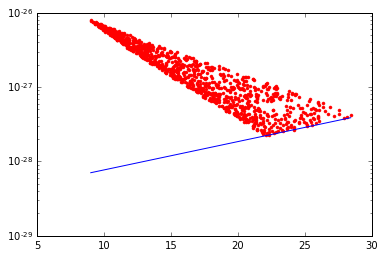

In [43]:
plt.semilogy(spf.Chi_1,spf.z2_sigmav,'r.')
plt.semilogy(spf.Chi_1,spf.AMS_ID_bb)


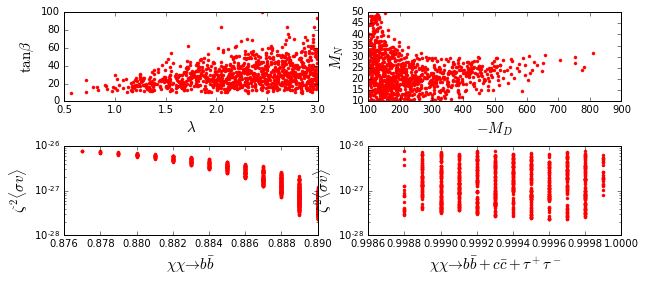

In [44]:
#fig, axes = plt.subplots(nrows=2, ncols=2)
#fig.tight_layout()
fig=plt.figure()
fig.subplots_adjust(hspace=0.5,wspace=0.2,left=0.01,right=1.3)
fig.add_subplot(221)
plt.plot(spf['lambda'],spf.tanb,'r.')
plt.xlabel(r'$\lambda$',size=15)
plt.ylabel(r'$\tan\beta$',size=15)
fig.add_subplot(222)
plt.plot(-spf.MDF,spf.MnINPUT,'r.')
plt.xlabel(r'$-M_D$',size=15)
plt.ylabel(r'$M_N$',size=15)
fig.add_subplot(223)
plt.semilogy(spf['ID_br:~chi,~chi > b b~'],spf.z2_sigmav,'r.')
plt.xlabel(r'$\chi\chi\to b\bar{b}$',size=15)
plt.ylabel(r'$\zeta^2\langle\sigma v\rangle$',size=15)
fig.add_subplot(224)
plt.semilogy(spf['ID_br:~chi,~chi > b b~']+spf['ID_br:~chi,~chi > c c~']+spf['ID_br:~chi,~chi > ta t'],spf.z2_sigmav,'r.')
plt.xlabel(r'$\chi\chi\to b\bar{b}+c \bar{c}+\tau^+\tau^-$',size=15)
plt.ylabel(r'$\zeta^2\langle\sigma v\rangle$',size=15)

Points satisfying all the constrains

In [ ]:
h_to_AA=2.270E-03
R_AA=np.array([1.15-0.25,1.15,1.15+0.27])

In [68]:
spf.shape

(1015, 148)

In [102]:
apf=spf[np.logical_or(spf['h0 ->  PHOT PHOT']/h_to_AA<R_AA[0],spf['h0 ->  PHOT PHOT']/h_to_AA>R_AA[2])]

In [80]:
plt.hlines?

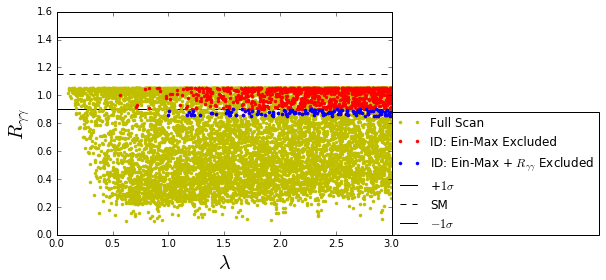

In [103]:
plt.plot(pf['lambda'],pf['h0 ->  PHOT PHOT']/h_to_AA,'y.',label='Full Scan')
plt.plot(spf['lambda'],spf['h0 ->  PHOT PHOT']/h_to_AA,'r.',label='ID: Ein-Max Excluded')
plt.plot(apf['lambda'],apf['h0 ->  PHOT PHOT']/h_to_AA,'b.',label=r'ID: Ein-Max + $R_{\gamma\gamma}$ Excluded')
plt.hlines(R_AA[0],0.,3,label=r'+$1\sigma$')
plt.hlines(R_AA[1],0.,3,linestyles='dashed',label='SM')
plt.hlines(R_AA[2],0.,3,label='$-1\sigma$')
plt.legend(loc=(1,0.))
plt.xlabel(r'$\lambda$',size=20)
plt.ylabel(r'$R_{\gamma\gamma}$',size=20)

(1e-29, 1e-25)

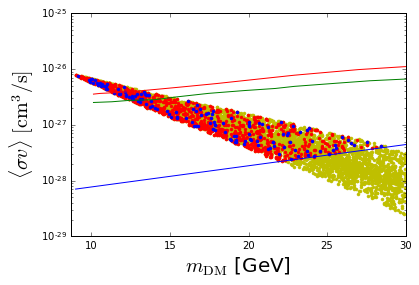

In [105]:
plt.semilogy(pf.Chi_1,pf.z2_sigmav,'y.')
plt.semilogy(spf.Chi_1,spf.z2_sigmav,'r.')
plt.semilogy(apf.Chi_1,apf.z2_sigmav,'b.')
plt.semilogy(pf.Chi_1,pf.AMS_ID_bb)
plt.semilogy(idb.MDF,idb.sigmav)
plt.semilogy(idm.MDF,idm.sigmav)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle\ [{\rm cm}^3/{\rm s}]$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.xlim(8.7,30)
plt.ylim(1E-29,1E-25)

In [46]:
spf[['Omega_h2','sigmav','Chi_1','Chi_2','Fre','h0 ->  Chi_1 Chi_1','Chi_2 ->  Chi_1 Z0',\
     'Chi_3 ->  Chi_1 Z0','Fre ->  Chi_1 W-','lux_SI','proton_SI','neutron_SI','lambda','tanb',\
    'ID_br:~chi,~chi > b b~']]

,Omega_h2,sigmav,Chi_1,Chi_2,Fre,h0 -> Chi_1 Chi_1,Chi_2 -> Chi_1 Z0,Chi_3 -> Chi_1 Z0,Fre -> Chi_1 W-,lux_SI,proton_SI,neutron_SI,lambda,tanb,"ID_br:~chi,~chi > b b~"
1812,0.1240,7.310000e-27,8.999038,-471.681713,107.127998,0.070210,0.046995,0.009026,1.000000,2.523718e-08,4.756000e-11,4.865000e-11,2.718981,28.302810,0.877
1839,0.1230,7.270000e-27,9.045528,-475.985891,112.228979,0.134381,0.048825,0.010035,1.000000,2.420032e-08,9.784000e-11,1.001000e-10,2.765808,32.147723,0.877
1872,0.1230,7.190000e-27,9.130613,-446.362231,111.816231,0.118148,0.053979,0.012447,1.000000,2.241171e-08,8.453000e-11,8.647000e-11,2.571289,31.060117,0.877
1873,0.1230,7.190000e-27,9.132469,-511.401437,129.095496,0.182589,0.051289,0.014113,1.000000,2.237421e-08,1.409000e-10,1.442000e-10,2.956518,38.924593,0.878
1941,0.1220,7.060000e-27,9.289344,-494.850830,135.117957,0.115932,0.057576,0.019522,1.000000,1.942079e-08,8.291000e-11,8.481000e-11,2.808107,36.754167,0.878
1942,0.1180,7.320000e-27,9.290680,-442.504616,102.400253,0.003108,0.050054,0.010317,1.000000,1.939738e-08,1.971000e-12,2.017000e-12,2.487868,22.718408,0.878
1956,0.1170,7.360000e-27,9.318806,-463.668577,105.269420,0.001632,0.047999,0.010069,1.000000,1.891126e-08,1.034000e-12,1.057000e-12,2.605057,23.075454,0.878
1974,0.1240,6.860000e-27,9.361653,-512.047142,152.096147,0.063487,0.063757,0.027835,1.000000,1.819400e-08,4.290000e-11,4.388000e-11,2.852773,38.269077,0.878
1981,0.1230,6.930000e-27,9.381835,-373.859132,108.268832,0.089572,0.070345,0.019746,1.000000,1.786564e-08,6.227000e-11,6.370000e-11,2.112321,28.151603,0.878
2009,0.1240,6.800000e-27,9.442659,-385.809282,117.194408,0.034643,0.073682,0.026040,1.000000,1.691145e-08,2.273000e-11,2.325000e-11,2.142112,27.848437,0.879


In [54]:
spf[np.logical_and(spf.Omega_h2>0.11,spf['lambda']<0.8)][['Omega_h2','lambda']]

,Omega_h2,lambda
10311,0.121,0.711271


In [112]:
for k in spf.keys():
    if k.find('ID_br')>-1:
        print k,spf[k].max()

 ID_br:~chi,~chi > 0.0
ID_br:~chi,~chi > H H 0.0
ID_br:~chi,~chi > W W 0.0
ID_br:~chi,~chi > Z H 0.0
ID_br:~chi,~chi > Z Z 0.0
ID_br:~chi,~chi > a W 0.0
ID_br:~chi,~chi > b b~ 0.89
ID_br:~chi,~chi > c c~ 0.0743
ID_br:~chi,~chi > d d~ 0.0
ID_br:~chi,~chi > mu m 0.000174
ID_br:~chi,~chi > s s~ 0.000478
ID_br:~chi,~chi > t t~ 0.0
ID_br:~chi,~chi > ta t 0.048
ID_br:~chi,~chi > u u~ 0.0
ID_br:~chi,~chi > v v 0.0
ID_br:~chi,~chi > vm vm 0.0
ID_br:~chi,~chi > vt vt 0.0


In [109]:
k='ID_br:~chi,~chi > v v'
k.find('ID_br')

0

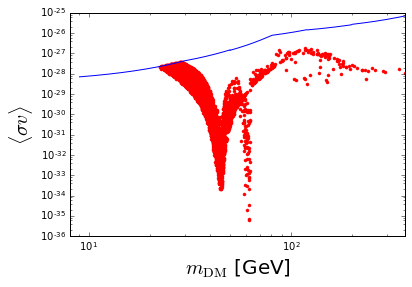

In [152]:
plt.loglog(spf.Chi_1,spf.z2_sigmav,'r.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)

(1e-28, 1e-26)

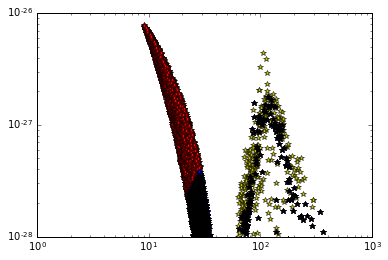

In [87]:

plt.loglog(pf.Chi_1,pf.z2_sigmav,'y*')
plt.loglog(ppf.Chi_1,ppf.z2_sigmav,'r*')
plt.loglog(svf.Chi_1,svf.z2_sigmav,'b*')
plt.loglog(hsv.Chi_1,hsv.z2_sigmav,'k*')
#plt.loglog(hpf[hpf.Fre>400].Chi_1,hpf[np.abs(hpf.Fre)>400].z2_sigmav,'b*')
#plt.plot(ppf.Chi_1) #From 1504.04276 see also 1508.06844
plt.ylim(1E-28,1E-26)

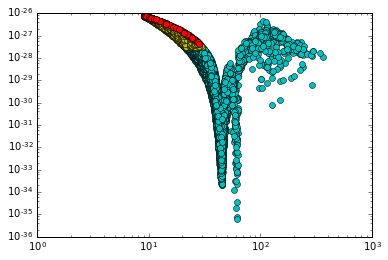

In [22]:
fpf=hpf[np.logical_and(hpf.Chi_1<60,hpf.z2_sigmav>3E-28)]
opf=fpf[np.logical_and(fpf.Omega_h2<Omega_h2_EXP[2],fpf.Omega_h2>Omega_h2_EXP[0])]
plt.loglog(pf.Chi_1,pf.z2_sigmav,'co')
plt.loglog(fpf.Chi_1,fpf.z2_sigmav,'yo')
plt.loglog(opf.Chi_1,opf.z2_sigmav,'ro')

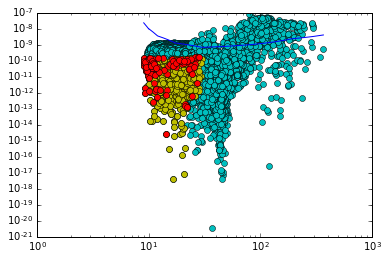

In [23]:
plt.loglog(pf.Chi_1,pf.z_DD_SI,'co')
plt.loglog(fpf.Chi_1,fpf.z_DD_SI,'yo')
plt.loglog(opf.Chi_1,opf.z_DD_SI,'ro')
plt.loglog(pf.sort_values('Chi_1').Chi_1,pf.sort_values('Chi_1').lux_SI,'b-')


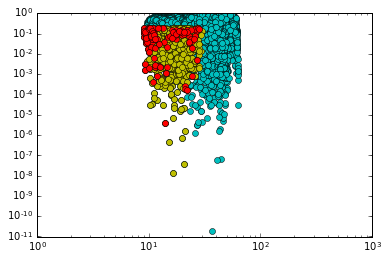

In [24]:
plt.loglog(pf.Chi_1,pf['h0 ->  Chi_1 Chi_1'],'co')
plt.loglog(fpf.Chi_1,fpf['h0 ->  Chi_1 Chi_1'],'yo')
plt.loglog(opf.Chi_1,opf['h0 ->  Chi_1 Chi_1'],'ro')

from http://arxiv.org/pdf/1505.03867v2.pdf fig 8
<img src="https://inspirehep.net/record/1370447/files/lowmass_1_m20.png">

In [543]:
start=time.time()
if 1==1:
    pf=pd.DataFrame()
    fulld=pd.DataFrame()
    v=a.vev
    #lambda_1=0.13
    mdf=-200; MN=40; tanb=100.;lam=0.35
    npoints=5000
    i=0
    for mdf in -np.logspace(np.log10(100),np.log10(1000),npoints):
        mdf=mdf*np.random.choice([1,-1])
        i=i+1
        if i%1000==0: print i
        ps=pd.Series()
        MN=np.exp(np.random.uniform(np.log(1),np.log(500)))
        tanb=20 #np.random.uniform(1,100)
        lam=1. #np.random.uniform(0.1,3)
        lu=lam*np.sin(np.arctan(tanb))
        ld=lam*np.cos(np.arctan(tanb))
        devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
        a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
        a.LHA.blocks['MINPAR'][2]='%0.8E       # MDF' %mdf
        a.LHA.blocks['MINPAR'][3]='%0.8E       # MnINPUT' %MN
        a.LHA.blocks['MINPAR'][4]='%0.8E       # lamuINPUT' %lu
        a.LHA.blocks['MINPAR'][5]='%0.8E       # lamdINPUT' %ld
        moc=a.runmicromegas(Direct_Detection=True)
        #print 'Omega h^2, SI proton, neutron, MChi =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI,\
        a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
    #manual pdgs:
        a.pdg['Frep']=-210000601
        #mof=run_feynrules_SDFDM(MDF = -a.Series.MDF,MN = a.Series.MnINPUT,\
        #                    lu = a.Series.lamuINPUT,ld = a.Series.lamdINPUT ,v=a.vev)
    #implement sigma_v
        #mo=a.micromegas_output(mof['Full'])
        a.branchings(a.LHA_out.decays,min_pdg=23) #Fill a.Br_names

                
        #print 'Omega h^2, SI proton, sigmav,Br_inv  =',mo.Omega_h2,mo.proton.SI,mo.sigmav,a.Br_names['h0 ->  Chi_1 Chi_1']
        #print a.Br_names['Fre ->  Chi_1 W-'],a.Br_names['Cha.Seriesi_2 ->  Chi_1 Z0']
        a.Series['sigma_chi0_chipm']=0.3 #pb from fig. 15 of arXiv:1411.1335
        a.Series['Chi_1']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
        a.Series['Chi_2']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_2]
        a.Series['Chi_3']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_3]
        a.Series['Fre']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Fre]
        ps=ps.append(a.Series)
        ps=ps.append(a.Br_names)
        #ps=ps.append(  mo.rename( {'Omega_h2':'Omega_h2_mo','proton_SI':'proton_SI_mo','neutron_SI':'neutron_SI_mo',\
        #                           'proton_SD':'proton_SD_mo','neutron_SD':'neutron_SD_mo','sigmav':'sigmav_mo',\
        #                             } )  )
        
        pf=pf.append(ps,ignore_index=True)
        pf=pf.fillna(0)
        #Full backup of data: WARNING: HUGE File
        fulls=pd.Series()
        if os.path.isfile('SPheno.spc.%s' %a.MODEL):
            f=open('SPheno.spc.%s' %a.MODEL).read()
            fulls['SPheno']=f
            fulls['micromegas']=moc
            
        fulld=fulld.append(fulls,ignore_index=True)

stop=time.time()
trun=stop-start
pd.DataFrame({'t':[trun]}).to_csv('trun.csv')

1000
2000
3000
4000
5000


In [554]:
import pandas as pd

In [553]:
if scan:
    pf.to_csv('fig8.csv',index=False)
    pf.shape

(5519, 172)

In [555]:
pf=pd.read_csv('fig8.csv')
#pf=pf.append( pd.read_csv('fig8_2.csv') )
pf=pf[pf.MDF<0]
pf.shape

(3012, 172)

In [556]:
pf['z2_sigmav']=pf.Omega_h2**2/Omega_h2_EXP[1]**2*pf.sigmav #sigmav calculated from feynrules implemenation
pf['tanb']=pf.lamuINPUT/pf.lamdINPUT
pf['lambda']=np.sqrt(pf.lamuINPUT**2+pf.lamdINPUT**2)
pf['lam']=pf['lambda']
pf['T_par']=stu.stumap(pf.MnINPUT.values,pf.MDF.values,pf.lam.values,pf.tanb.values,vev=a.vev)
pf['DD_SI']=0
if pf[pf.proton_SI>pf.neutron_SI].shape[0]==0:
    pf['DD_SI']=pf.neutron_SI
else:
    for i in range(pf.shape[0]):
        pf=pf.reset_index(drop=True)
        pf.loc[i,'DD_SI']=max(pf.proton_SI[i],pf.neutron_SI[i])
pf['z_DD_SI']=pf.Omega_h2/Omega_h2_EXP[1]*pf.DD_SI
LUX=multicurvefit()
LUX.read_json('lux2016.json')
pf['lux_SI']=LUX(pf.Chi_1,verbose=False)

In [557]:
f8=pf
nl=17
print '-'*nl
print '| all |', pf.shape[0],'  |'
cf=pd.Series()
cf['a']=f8[f8.Omega_h2>Omega_h2_EXP[2]]
print '-'*nl
print '| a   |', cf.a.shape[0],'  |'
cf['b']=f8[f8.T_par>0.2]
print '-'*nl
print '| b   |', cf.b.shape[0],'  |'
cf['c']=cf.b[cf.b['h0 ->  Chi_1 Chi_1']<0.19]
print '-'*nl
print '| c   |', cf.c.shape[0],'  |'
#cf['d']=f8[np.logical_and(cf.c['h0 ->  PHOT PHOT']/h_to_AA>R_AA[0],cf.c['h0 ->  PHOT PHOT']/h_to_AA<R_AA[2])]
#print '-'*nl
#print '| d   |', cf.d.shape[0],'  |'
#cf['e']=cf.d[cf.d.LHC_cs_br<cf.d.LHC_exc_cs]
#print '-'*nl
#print '| e   |', cf.e.shape[0],'  |'
cf['f']=f8[f8.z_DD_SI<f8.lux_SI]
print '-'*nl
print '| f   |', cf.f.shape[0],'   |'
print '-'*nl


-----------------
| all | 3012   |
-----------------
| a   | 1876   |
-----------------
| b   | 1432   |
-----------------
| c   | 605   |
-----------------
| f   | 1240    |
-----------------


In [558]:
of8=Oh2(f8)

(0, 300)

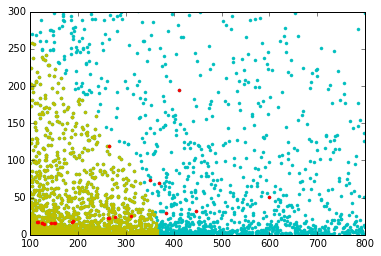

In [562]:
plt.plot(f8.MDF.abs(),f8.MnINPUT,'c.')
plt.plot(cf.b.MDF.abs(),cf.b.MnINPUT,'y.')
plt.plot(of8.MDF.abs(),of8.MnINPUT,'r.')
plt.xlim(100,800)
plt.ylim(0,300)

In [185]:
K=np.array([[1,2],[3,1]])
K

array([[1, 2],
       [3, 1]])

In [184]:
K.T

array([[1, 3],
       [2, 1]])

In [186]:
K.transpose()

array([[1, 3],
       [2, 1]])

[Jupyter home](./draft.pdf)